# ArcFace Toy Example #
---
- This is a toy example of [ArcFace: Additive Angular Margin Loss for Deep Face Recognition](https://arxiv.org/abs/1801.07698)
- You can use Trainer class here : [PinkBlack](https://github.com/sweetcocoa/PinkBlack)
  - Still You can train without a trainer if you use the structure of network only.

## Description ##
---
- Dataset : MNIST
- Network : 
  - Feature extractor :: Custom 3-layered Conv (No Residual Connection)
  - Classifier :: 1 Linear Layer (No Bias)
- Loss :
  - Softmax
  - ArcLoss
- Task :
  - Multi-Class Classification

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import math
import PinkBlack.trainer
import matplotlib.pyplot as plt
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [3]:
transform = transforms.Compose([
transforms.Resize((28, 28)),
transforms.ToTensor(),
])

train_dataset = datasets.MNIST('mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist', train=False, transform=transform)
train_dataloader = DataLoader(train_dataset, pin_memory=True, num_workers=8, shuffle=True, batch_size=32)
test_dataloader = DataLoader(test_dataset, pin_memory=True, num_workers=8, batch_size=32, shuffle=False)

In [4]:
# softmax 사용 일반 네트워크
# visualize를 위해 feature dimension 은 2
class SoftMaxNet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.ext = nn.Sequential(
            nn.Conv2d(1, 256, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 2, 5),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(2, 10)
        
    def forward(self, x):
        x = self.ext(x)
        x = x.view(x.shape[0], 2)
#         x = F.normalize(x)
        x = self.classifier(x)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.ext(x)
            x = x.view(x.shape[0], 2)
            x = F.normalize(x)
            return x
        

In [8]:
# ArcFace의 Feature extractor 부분
# Classifier 를 여기 선언한 이유는 코딩의 용이성을 위해
class ArcLossFeatureExtractor(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.ext = nn.Sequential(
            nn.Conv2d(1, 256, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 2, 5),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Parameter(torch.FloatTensor(10, 2))
        nn.init.xavier_normal_(self.classifier)

    def forward(self, x):
        x = self.ext(x)
        x = x.view(x.shape[0], 2)
        x = F.normalize(x) # B x 2
#         denom = torch.norm(x, dim=1, keepdim=True).clamp(min=1e-12)
#         x = x / denom
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.ext(x)
            x = x.view(x.shape[0], 2)
            x = F.normalize(x)
            return x

In [6]:
# loss layer
# ArcLoss(feature extract layer)
# input : batch_size x 2 (feature vector), batch_size(long, label)
# 주의 : arc-cosine 함수는 x=-1, 1에서 미분값이 nan이므로, clamp할 때 주의해야함. (어디서 nan 뜨는지 몰라서 고생하였음)
class ArcLoss(nn.Module):
    def __init__(self, feat):
        super(self.__class__, self).__init__()

        self.classifier = feat.classifier
    
        self.margin = 0.2
        self.scale = 30.0
        
        self.cos_m = math.cos(self.margin)
        self.sin_m = math.sin(self.margin)
        self.eps = 0.0001
        self.th = math.cos(math.pi - self.margin)
        self.mm = math.sin(math.pi - self.margin) * self.margin
    
    def forward(self, x, y):        
        outputs = self.logit(x, y)
        loss = F.cross_entropy(outputs, y)
        return loss

    def logit(self, x, y):
        cosine = F.linear(x, F.normalize(self.classifier)) # weight shape 2 x 10 without bias
        cosine = cosine.clamp(-1. + self.eps, 1. - self.eps) 
        theta = torch.acos(cosine) # clamp에서 eps를 뺀 이유 : grad nan을 막기 위해 (d(arccos)/dx == nan at x = -1, 1) 
        cosine_m = torch.where(theta < (math.pi - self.margin), torch.cos(theta + self.margin), torch.cos(theta) - self.mm)
        
        ## acos 안 쓰고 cosine domain에서 계산 -> 못미더워서 그냥 acos으로 바꿈
        #sine = torch.sqrt(1. - torch.pow(cosine, 2))        
        #cosine_m = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m) = cos(theta)cos(m) - sin(the2ta)sin(m)
        #cosine_m = torch.where(cosine > self.th, cosine_m, cosine - self.mm)

        if y.dim() == 1:
            y = y.unsqueeze(-1)

        onehot = torch.zeros(cosine.size()).cuda()
        onehot.scatter_(1, y, 1)
        outputs = onehot * cosine_m + (1.0 - onehot) * cosine
        outputs = outputs * self.scale
        if self.printcount < 0:
            print(outputs, self.classifier)
            print()
            self.printcount += 1
        
        if y.dim() == 2:
            y = y.squeeze()

        return outputs
    
class Metric:
    def __init__(self, loss):
        self.loss = loss
    
    def __call__(self, x, y):
        with torch.no_grad():
            logit = self.loss.logit(x, y)
            return PinkBlack.trainer.cal_accuracy(logit, y)

    

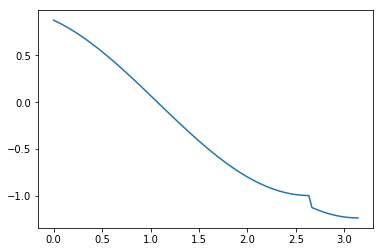

In [12]:
# theta에 따른 cosine(theta + m) 곡선 그려보기
margin = 0.5
cos_m = math.cos(margin)
sin_m = math.sin(margin)
th = math.cos(math.pi - margin)
mm = math.sin(math.pi - margin) * margin
x = np.linspace(0, np.pi, 100)
cos = np.cos(x + margin)
y = np.where(np.cos(x) > th, cos, np.cos(x) - mm)
plt.plot(x, y)
plt.show()

In [14]:
arcfeat = ArcLossFeatureExtractor().cuda()
arcloss = ArcLoss(arcfeat).cuda()
metric = Metric(loss=arcloss)
# arcloss.register_backward_hook(lambda *pargs: print("after", arcloss.classifier) if arcloss.printcount < 10 else None)
arc_trainer = PinkBlack.trainer.Trainer(net=arcfeat, train_dataloader=train_dataloader, val_dataloader=test_dataloader, criterion=arcloss, metric=metric)

In [15]:
arc_trainer.load("ckpt/arcloss.pth")
# arc_trainer.train(epoch=20)

Loaded, defaultdict(<class 'float'>, {'max_val_metric': 0.9383985623003195, 'logdir': './pinkblack_autolog/', 'timestamp': '20190412_110051', 'clip_gradient_norm': False, 'epoch': 20.0, 'train_loss': 0.11006658310890198, 'train_metric': 0.9770333333333333, 'val_loss': 0.4626310970455694, 'val_metric': 0.9383985623003195})


In [16]:
# arc_trainer.save("ckpt/arcloss.pth")

In [17]:
softmax_net = SoftMaxNet().cuda()
trainer = PinkBlack.trainer.Trainer(net=softmax_net, train_dataloader=train_dataloader, val_dataloader=test_dataloader)
# trainer.train(epoch=20)
trainer.load("ckpt/softmax.pth")

Loaded, defaultdict(<class 'float'>, {'max_val_metric': 0.9623602236421726, 'logdir': './pinkblack_autolog/', 'timestamp': '20190412_104055', 'clip_gradient_norm': False, 'epoch': 20.0, 'train_loss': 0.023165195095539094, 'train_metric': 0.99255, 'val_loss': 0.24522033819375327, 'val_metric': 0.9623602236421726})


In [18]:
# trainer.save("ckpt/softmax.pth")

In [23]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Softmax Visualize

In [21]:
def get_samples_vector(net, dataloader, number=1000):
    samples = []
    labels = []
    for x, y in dataloader:
        sample = net.get_feature(x.cuda()) # normalized vector
    #     with torch.no_grad():
    #         sample = net.ext(x.cuda()).view(x.shape[0], 2)
        samples.extend(sample.tolist())
        labels.extend(y.tolist())
        if len(samples) > 1000:
            break
    samples = list(zip(samples, labels))
    return samples, labels

In [20]:
def show_2d_space(samples, labels, w):
    plt.figure(figsize=(10,10))
    for i in range(10):
        samples_i = list(filter(lambda x : x[1] == i, samples))
        samples_feat = np.ndarray.flatten(np.array([s[0] for s in samples_i]))
        plt.plot(*samples_feat, marker="o", color=colors[i], markersize=1)
        plt.plot([w[i][0], 0], [w[i][1], 0], color=colors[i])
    # plt.plot(*zip(w, [[0,0] for i in range(10)]))
    plt.show()    

In [20]:
w = F.normalize(net.classifier.weight).tolist()

# Softmax Example

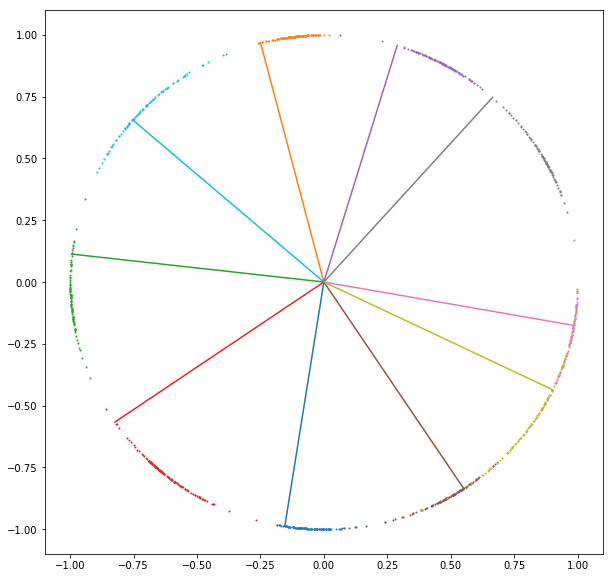

In [24]:
softmax_samples, softmax_labels = get_samples_vector(softmax_net, dataloader=train_dataloader, number=1000)
softmax_w = F.normalize(softmax_net.classifier.weight).tolist()
show_2d_space(softmax_samples, softmax_labels, softmax_w)

# ArcLoss Example

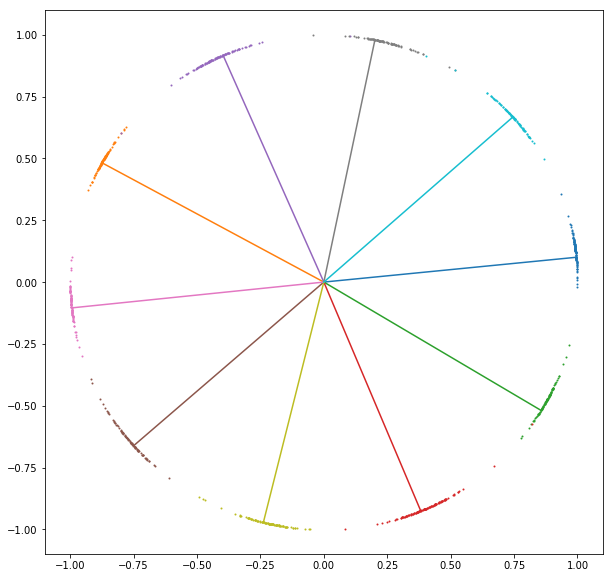

In [26]:
arcloss_samples, arcloss_labels = get_samples_vector(arcfeat, dataloader=train_dataloader, number=1000)
arcloss_w = F.normalize(arcfeat.classifier).tolist()
show_2d_space(arcloss_samples, arcloss_labels, arcloss_w)